In [1]:
# Modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import argparse
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from scipy.integrate import odeint, solve_ivp
# Parameters
n_neurons = 50 # hidden nodes in each layer
lr = 0.001 # learning rate, optimizer
criterion = nn.MSELoss()
n_epochs = 100 #70000 # total epoch to train
n_col = 3000
timesteps = 100
time_limit = 1
# Model parameters
nu = 0.01/np.pi

In [2]:
# Temporal discretization
t = np.linspace(0,time_limit,timesteps)
t_b = np.array([0])
#sptaial discretization
N = 200
L = 2
x = np.linspace(-L/2, L/2, N, endpoint=False)
# Initial conditions
u0 = -np.sin(np.pi*x)

# Numerical solution
y_init = [3,0] # [3,1]
#solution = solve_ivp(sho, [0,timesteps], y0 = y_init, t_eval = t)
#sol_data = solution.y[0]
#sol_plot = np.array([sol_data])
# Measurements
#u_b = [sol_data[0]] #,sol_data[5]] #,sol_data[40],sol_data[100],sol_data[150],sol_data[198]]
#n_b = len(u_b)
#u_b = np.array([u_b])
#t_b = [t[0]] #,t[5]] #,t[40],t[100],t[150],t[198]]
#t_b = np.array([t_b])

# Spatial discretization, collocation/sampling nodes
x_col = np.linspace(0, time_limit, n_col)
x_col = Variable(torch.from_numpy(x_col).float(), requires_grad=True).to(device)
t_b = Variable(torch.from_numpy(t_b).float(), requires_grad=True).to(device)
u_b = Variable(torch.from_numpy(u_b).float(), requires_grad=True).to(device)
t_plot = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
t_plot = t_plot.reshape(timesteps,1)


In [ ]:
x_col = x_col.reshape(n_col,1)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, n_neurons)
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc3 = nn.Linear(n_neurons,n_neurons)
        self.fc4 = nn.Linear(n_neurons,n_neurons)
        self.fc5 = nn.Linear(n_neurons,N)
    # forward method
    def forward(self,y):
        y = torch.tanh(self.fc1(y))
        y = torch.tanh(self.fc2(y))
        y = torch.tanh(self.fc3(y))
        y = torch.tanh(self.fc4(y))
        return self.fc5(y)
net = PINN().to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)

def compute_residuals(x):
    dx = L/N
    u = net(x)
    u_t = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True,create_graph=True)[0] # computes dy/dx # Dive into what this does
    udx = (u-net(x-dx))/dx
    uddx = (net(x+dx)-2*u+net(x-dx))/dx**2
    r_ode = u_t + u*udx- nu*uddx
    return r_ode


In [4]:
def train(x_col,u_b):
    optimizer.zero_grad()
    # boundary loss
    net_u_b = net(0)
    MSE_u = criterion(net_u_b,u0)
    # collocation loss
    res = compute_residuals(x_col)
    col_target = torch.zeros_like(res)
    MSE_f = criterion(res,col_target)
    loss = MSE_u/N + MSE_f /N
    loss.backward()
    optimizer.step()
    return loss.data.item()

[1/100]: loss: 8.9709
[2/100]: loss: 8.7024
[3/100]: loss: 8.4410
[4/100]: loss: 8.1841
[5/100]: loss: 7.9299
[6/100]: loss: 7.6768
[7/100]: loss: 7.4233
[8/100]: loss: 7.1686
[9/100]: loss: 6.9122
[10/100]: loss: 6.6541
[11/100]: loss: 6.3947
[12/100]: loss: 6.1349
[13/100]: loss: 5.8757
[14/100]: loss: 5.6188
[15/100]: loss: 5.3658
[16/100]: loss: 5.1186
[17/100]: loss: 4.8791
[18/100]: loss: 4.6490
[19/100]: loss: 4.4300
[20/100]: loss: 4.2233
[21/100]: loss: 4.0297
[22/100]: loss: 3.8500
[23/100]: loss: 3.6840
[24/100]: loss: 3.5316
[25/100]: loss: 3.3921
[26/100]: loss: 3.2647
[27/100]: loss: 3.1484
[28/100]: loss: 3.0420
[29/100]: loss: 2.9443
[30/100]: loss: 2.8543
[31/100]: loss: 2.7708
[32/100]: loss: 2.6928
[33/100]: loss: 2.6196
[34/100]: loss: 2.5504
[35/100]: loss: 2.4847
[36/100]: loss: 2.4221
[37/100]: loss: 2.3620
[38/100]: loss: 2.3044
[39/100]: loss: 2.2490
[40/100]: loss: 2.1957
[41/100]: loss: 2.1443
[42/100]: loss: 2.0949
[43/100]: loss: 2.0474
[44/100]: loss: 2.00

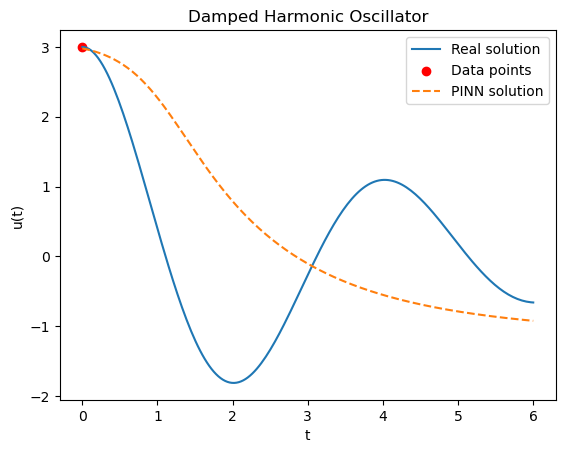

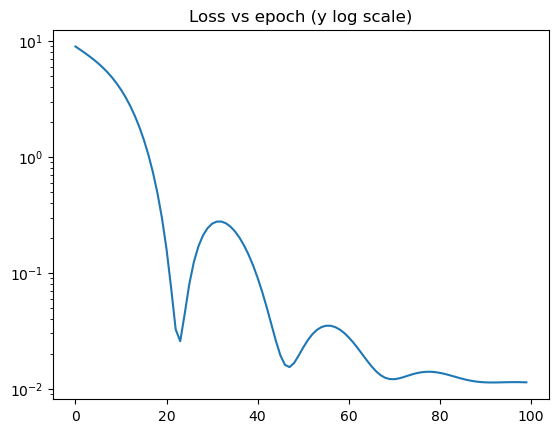

In [5]:
losses = []
for epoch in range(1, n_epochs+1):
    losses.append(train(x_col,u_b))
    print('[%d/%d]: loss: %.4f' % ((epoch), n_epochs, torch.mean(torch.FloatTensor(losses))))
with torch.no_grad():
    y = net(t_plot)
    plt.plot(t,sol_data,label='Real solution')
    plt.scatter(t_b,u_b,color='red',label='Data points')
    plt.plot(t,y,'--',label='PINN solution')
    plt.xlabel('t')
    plt.ylabel('u(t)')
    plt.title('Damped Harmonic Oscillator')
    plt.legend()
    plt.show()
    
e_plot = list(range(n_epochs))
plt.plot(e_plot,losses)
plt.yscale('log')
plt.title('Loss vs epoch (y log scale)')
plt.show()


In [32]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np


def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.6)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=8000, num_boundary=320, num_initial=640
)
net = dde.nn.FNN([2] + [40] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=10000)
#model.compile("L-BFGS")
#losshistory, train_state = model.train(iterations=10)
#dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))


Compiling model...
'compile' took 0.002258 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.94e-03, 1.44e-02, 5.81e-01]    [7.94e-03, 1.44e-02, 5.81e-01]    []  
1000      [1.50e-02, 1.27e-03, 3.37e-02]    [1.50e-02, 1.27e-03, 3.37e-02]    []  
2000      [8.76e-03, 1.04e-04, 2.79e-02]    [8.76e-03, 1.04e-04, 2.79e-02]    []  
3000      [6.84e-03, 1.47e-04, 2.30e-02]    [6.84e-03, 1.47e-04, 2.30e-02]    []  
4000      [5.71e-03, 5.99e-05, 2.07e-02]    [5.71e-03, 5.99e-05, 2.07e-02]    []  
5000      [5.01e-03, 4.19e-05, 1.67e-02]    [5.01e-03, 4.19e-05, 1.67e-02]    []  
6000      [3.77e-03, 3.21e-05, 9.67e-03]    [3.77e-03, 3.21e-05, 9.67e-03]    []  
7000      [2.61e-03, 1.83e-05, 4.99e-03]    [2.61e-03, 1.83e-05, 4.99e-03]    []  
8000      [1.84e-03, 6.10e-06, 1.99e-03]    [1.84e-03, 6.10e-06, 1.99e-03]    []  
9000      [1.31e-03, 2.88e-06, 9.37e-04]    [1.31e-03, 2.88e-06, 9.37e-04]    []  
10000     [8.62

-59.700012


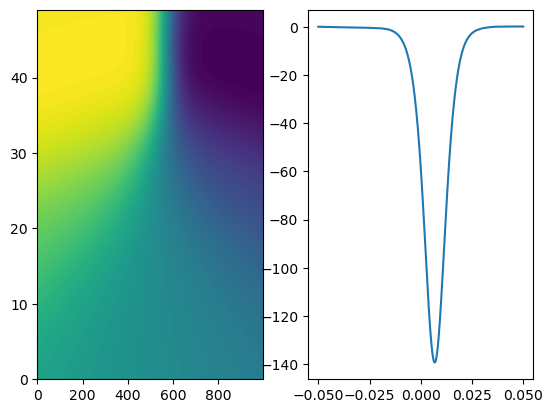

In [31]:
N_X, N_T = 1000, 50
x = np.linspace(-0.05, 0.05, N_X)
t = np.linspace(0, 0.6, N_T)
X, T = np.meshgrid(x, t)
X_star = np.vstack((X.ravel(), T.ravel())).T
y_star = model.predict(X_star)
y = np.reshape(y_star,(N_T,N_X))

t_find = 1.6037/np.pi
t_index = np.where(t>=t_find)[0][0]

#now computing the gradient of y in x
L = x[-1]-x[0]
dx = L/N_X
dy = (-y[t_index,0:N_X-1] + y[t_index,1:])/dx
test_val = dy[N_X//2]
print(test_val)

fig, ax = plt.subplots(1,2)
ax[0].contourf(y, 100, cmap="viridis")
ax[1].plot(x[:-1],dy)